In [209]:
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import cv2
import fnmatch
import os
import glob

In [210]:
df = pd.read_csv('data.txt', sep=" ", header=None)
df_normal_marked = pd.read_csv('saved.csv')
df.columns = ["ID", "background_tissue", "class",
              "severity", "x", "y", "rad"]
df = df.dropna()
df.index = df.index + 1

In [211]:
df_normal_marked['severity'] = 'N'

In [212]:
df_final = pd.concat([df, df_normal_marked], axis=0)

In [213]:
df_final

,ID,background_tissue,class,severity,x,y,rad,Unnamed: 0
1,mdb001,G,CIRC,B,535,425,197.0,NaN
2,mdb002,G,CIRC,B,522,280,69.0,NaN
5,mdb005,F,CIRC,B,477,133,30.0,NaN
6,mdb005,F,CIRC,B,500,168,26.0,NaN
11,mdb010,F,CIRC,B,525,425,33.0,NaN
...,...,...,...,...,...,...,...,...
188,mdb318,D,NORM,N,442,68,50.0,202.0
189,mdb319,D,NORM,N,590,281,50.0,203.0
190,mdb320,D,NORM,N,495,264,50.0,204.0
191,mdb321,D,NORM,N,604,271,50.0,205.0


In [214]:
df_final = df_final.reset_index(drop=True)
del df_final["Unnamed: 0"]

In [215]:
df_final

,ID,background_tissue,class,severity,x,y,rad
0,mdb001,G,CIRC,B,535,425,197.0
1,mdb002,G,CIRC,B,522,280,69.0
2,mdb005,F,CIRC,B,477,133,30.0
3,mdb005,F,CIRC,B,500,168,26.0
4,mdb010,F,CIRC,B,525,425,33.0
...,...,...,...,...,...,...,...
307,mdb318,D,NORM,N,442,68,50.0
308,mdb319,D,NORM,N,590,281,50.0
309,mdb320,D,NORM,N,495,264,50.0
310,mdb321,D,NORM,N,604,271,50.0


In [254]:
def img_erode():
    for index, row in df_final.iterrows():
        path = 'all-mias/{name}.pgm'.format(name=row['ID'])
        im = cv2.imread('all-mias/{name}.pgm'.format(name=row['ID']), 0)
        #img = cv2.imread('j.png',0)
        kernel = np.ones((5,5),np.uint8)
        erosion = cv2.erode(im,kernel,iterations=1) 
        cv2.imwrite('erode/{}.png'.format(row['ID']), erosion)
img_erode()

In [231]:
def img_canny():
    for index, row in df_final.iterrows():
        path = 'all-mias/{name}.pgm'.format(name=row['ID'])
        im = cv2.imread('all-mias/{name}.pgm'.format(name=row['ID']))
        img_cvt=cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        fin = cv2.Canny(img_cvt,10,20)
        cv2.imwrite('canny/{}.png'.format(row['ID']), fin)
img_canny()

In [121]:
df_normal = pd.read_csv('data.txt', sep=" ", header=None)
df_normal.columns = ["ID", "background_tissue", "class",
              "severity", "x", "y", "rad"]

In [122]:
df_normal = df_normal.loc[df_normal['class']  == 'NORM']
df_normal = df_normal.reset_index(drop=True)

In [123]:
df_normal

,ID,background_tissue,class,severity,x,y,rad
0,mdb003,D,NORM,NaN,NaN,NaN,NaN
1,mdb004,D,NORM,NaN,NaN,NaN,NaN
2,mdb006,F,NORM,NaN,NaN,NaN,NaN
3,mdb007,G,NORM,NaN,NaN,NaN,NaN
4,mdb008,G,NORM,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
202,mdb318,D,NORM,NaN,NaN,NaN,NaN
203,mdb319,D,NORM,NaN,NaN,NaN,NaN
204,mdb320,D,NORM,NaN,NaN,NaN,NaN
205,mdb321,D,NORM,NaN,NaN,NaN,NaN


In [124]:
df['severity'].value_counts()

B    69
M    54
Name: severity, dtype: int64

In [10]:
im = Image.open('all-mias/mdb001.pgm') # PILLOW image processing

In [11]:
im.getpixel( (535,425) )

155

In [110]:
last = 'start'

In [111]:
def img_draw(image, x, y, r, c):
    if c=='M':
        color = 'red'
    else:
        color = 'blue'
    draw = ImageDraw.Draw(image)
    leftUpPoint = (x-r, y-r)
    rightDownPoint = (x+r, y+r)
    twoPointList = [leftUpPoint, rightDownPoint]
    draw.ellipse(twoPointList, outline=color, width=5)

In [ ]:
for index, row in df.iterrows():
    path = 'all-mias/{name}.pgm'.format(name=row['ID'])
    if last != path:
        im = Image.open(path).convert("RGB")
    x = int(row['x'])
    y = int(row['y'])
    r = int(row['rad'])
    c = row['severity']
    img_draw(im, x, 1024 - y, r, c)
    im.save("marked/{}.png".format(row['ID']))
    last = path

In [147]:
df_final

,ID,background_tissue,class,severity,x,y,rad
0,mdb001,G,CIRC,B,535,425,197.0
1,mdb002,G,CIRC,B,522,280,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477,133,30.0
...,...,...,...,...,...,...,...
518,mdb318,D,NORM,NaN,442,68,50.0
519,mdb319,D,NORM,NaN,590,281,50.0
520,mdb320,D,NORM,NaN,495,264,50.0
521,mdb321,D,NORM,NaN,604,271,50.0


In [232]:
## CANNNY
mean = []
var = []
std = []
max_v = []
min_v = []
min_coor_x = []
min_coor_y = []
max_coor_x = []
max_coor_y = []
for index, row in df_final.iterrows():
    path = 'canny/{name}.png'.format(name=row['ID'])
    im = cv2.imread('canny/{name}.png'.format(name=row['ID']))
    h,w,d = im.shape
    x = int(row['x'])
    y = int(row['y'])
    r = int(row['rad'])
    #c = row['severity']
    mask = np.zeros((h,w), np.uint8)
    cv2.circle(mask,(x,1024-y),r ,1,thickness=-1)
    masked_data = cv2.bitwise_and(im, im, mask=mask)
    
    mean.append(cv2.meanStdDev(im, mask = mask)[0][0])
    var.append(np.power(cv2.meanStdDev(im, mask = mask)[1][0], 2))
    std.append(cv2.meanStdDev(im, mask = mask)[1][0])
    
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(gray, mask = mask)
    
    max_v.append(max_val)
    min_v.append(min_val)
    min_coor_x.append(min_loc[0])
    min_coor_y.append(min_loc[1])
    max_coor_x.append(max_loc[0])
    max_coor_y.append(max_loc[1])


In [255]:
## Erode
mean = []
var = []
std = []
max_v = []
min_v = []
min_coor_x = []
min_coor_y = []
max_coor_x = []
max_coor_y = []
for index, row in df_final.iterrows():
    path = 'erode/{name}.png'.format(name=row['ID'])
    im = cv2.imread('erode/{name}.png'.format(name=row['ID']))
    h,w,d = im.shape
    x = int(row['x'])
    y = int(row['y'])
    r = int(row['rad'])
    #c = row['severity']
    mask = np.zeros((h,w), np.uint8)
    cv2.circle(mask,(x,1024-y),r ,1,thickness=-1)
    masked_data = cv2.bitwise_and(im, im, mask=mask)
    
    mean.append(cv2.meanStdDev(im, mask = mask)[0][0])
    var.append(np.power(cv2.meanStdDev(im, mask = mask)[1][0], 2))
    std.append(cv2.meanStdDev(im, mask = mask)[1][0])
    
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(gray, mask = mask)
    
    max_v.append(max_val)
    min_v.append(min_val)
    min_coor_x.append(min_loc[0])
    min_coor_y.append(min_loc[1])
    max_coor_x.append(max_loc[0])
    max_coor_y.append(max_loc[1])


In [256]:
df_final['mean_erode'] = np.array(mean)
df_final['var_erode'] = np.array(var)
df_final['std_erode'] = np.array(std)
df_final['min_pixel_erode'] = np.array(min_v)
df_final['max_pixel_erode'] = np.array(max_v)
df_final['min_coor_x_erode'] = np.array(min_coor_x)
df_final['min_coor_y_erode'] = np.array(min_coor_y)
df_final['max_coor_x_erode'] = np.array(max_coor_x)
df_final['max_coor_y_erode'] = np.array(max_coor_y)

In [233]:
df_final['mean_canny'] = np.array(mean)
df_final['var_canny'] = np.array(var)
df_final['std_canny'] = np.array(std)
df_final['min_pixel_canny'] = np.array(min_v)
df_final['max_pixel_canny'] = np.array(max_v)
df_final['min_coor_x_canny'] = np.array(min_coor_x)
df_final['min_coor_y_canny'] = np.array(min_coor_y)
df_final['max_coor_x_canny'] = np.array(max_coor_x)
df_final['max_coor_y_canny'] = np.array(max_coor_y)

In [216]:
mean = []
var = []
std = []
max_v = []
min_v = []
min_coor_x = []
min_coor_y = []
max_coor_x = []
max_coor_y = []
for index, row in df_final.iterrows():
    path = 'all-mias/{name}.pgm'.format(name=row['ID'])
    im = cv2.imread('all-mias/{name}.pgm'.format(name=row['ID']))
    h,w,d = im.shape
    x = int(row['x'])
    y = int(row['y'])
    r = int(row['rad'])
    #c = row['severity']
    mask = np.zeros((h,w), np.uint8)
    cv2.circle(mask,(x,1024-y),r ,1,thickness=-1)
    masked_data = cv2.bitwise_and(im, im, mask=mask)
    
    mean.append(cv2.meanStdDev(im, mask = mask)[0][0])
    var.append(np.power(cv2.meanStdDev(im, mask = mask)[1][0], 2))
    std.append(cv2.meanStdDev(im, mask = mask)[1][0])
    
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(gray, mask = mask)
    
    max_v.append(max_val)
    min_v.append(min_val)
    min_coor_x.append(min_loc[0])
    min_coor_y.append(min_loc[1])
    max_coor_x.append(max_loc[0])
    max_coor_y.append(max_loc[1])


In [217]:
df_final['mean'] = np.array(mean)
df_final['var'] = np.array(var)
df_final['std'] = np.array(std)
df_final['min_pixel'] = np.array(min_v)
df_final['max_pixel'] = np.array(max_v)
df_final['min_coor_x'] = np.array(min_coor_x)
df_final['min_coor_y'] = np.array(min_coor_y)
df_final['max_coor_x'] = np.array(max_coor_x)
df_final['max_coor_y'] = np.array(max_coor_y)

In [257]:
df_final

,ID,background_tissue,class,severity,x,y,rad,mean,var,std,...,std_canny,mean_erode,var_erode,std_erode,min_pixel_erode,max_pixel_erode,min_coor_x_erode,min_coor_y_erode,max_coor_x_erode,max_coor_y_erode
0,mdb001,G,CIRC,B,535,425,197.0,150.781051,3205.504934,56.617179,...,112.945588,145.328215,3258.043762,57.079276,5.0,217.0,371,708,584,598
1,mdb002,G,CIRC,B,522,280,69.0,197.870827,764.537398,27.650269,...,103.247451,193.119138,904.499352,30.074896,58.0,226.0,569,794,528,676
2,mdb005,F,CIRC,B,477,133,30.0,149.605105,409.222292,20.229243,...,117.540999,142.003899,500.080453,22.362479,76.0,174.0,464,918,475,876
3,mdb005,F,CIRC,B,500,168,26.0,162.426214,80.178549,8.954248,...,116.307381,156.487977,94.573288,9.724880,126.0,173.0,493,831,521,861
4,mdb010,F,CIRC,B,525,425,33.0,184.385157,127.091607,11.273491,...,119.127056,178.766207,134.473062,11.596252,154.0,200.0,558,599,520,599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,mdb318,D,NORM,N,442,68,50.0,14.033015,0.505857,0.711236,...,12.200599,13.095857,0.230200,0.479791,11.0,14.0,434,949,442,906
308,mdb319,D,NORM,N,590,281,50.0,145.912938,28.130725,5.303841,...,118.449283,141.277884,21.720868,4.660565,130.0,159.0,585,776,639,743
309,mdb320,D,NORM,N,495,264,50.0,195.578840,470.810515,21.698168,...,108.471641,190.905163,514.108278,22.673956,145.0,224.0,486,809,524,720
310,mdb321,D,NORM,N,604,271,50.0,177.764946,30.464061,5.519426,...,118.201415,173.387763,24.682272,4.968126,163.0,191.0,624,738,555,747


In [258]:
df_final.to_csv("finErode.csv")

In [259]:
all_coor = []
def get_all_coor():
    for index, row in df_final.iterrows():
        coordinates = []
        for x in range( int(row['x']) - int(row['rad']) ,  int(row['x']) + int(row['rad']) ) :
            for y in range( int(row['y']) - int(row['rad']), int(row['y']) + int(row['rad']) ):
                dx = x - int(row['x'])
                dy = y - int(row['y'])
                distanceSquared = dx * dx + dy * dy
                if (distanceSquared <= row['rad']**2):
                    coordinates.append((x,y))
        all_coor.append(coordinates)

In [260]:
get_all_coor()

In [261]:
bdips = []
#original is all-mias
def bdip():    
    for index, row in df_final.iterrows():
        path = 'erode/{name}.png'.format(name=row['ID'])
        im = cv2.imread('erode/{name}.png'.format(name=row['ID']))
        s = 0
        for x, y in all_coor[index]:
            s += im[row['max_coor_y'],row['max_coor_x']] - im[y, x]
        bdips.append( (s[0]/(row['rad']**2*3.14*im[row['max_coor_y'],row['max_coor_x']]))[0] )    

In [80]:
im = cv2.imread('all-mias/mdb001.pgm')

In [262]:
bdip()
bdips

<ipython-input-261-1b548d193135>:10: RuntimeWarning: divide by zero encountered in true_divide
  bdips.append( (s[0]/(row['rad']**2*3.14*im[row['max_coor_y'],row['max_coor_x']]))[0] )


[7.625498936395408e-06,
 6.33241334961923e-05,
 1.0286541911486364e-05,
 0.0006198834817417039,
 7.347835079428774e-06,
 2.575871112776321e-05,
 7.647594754973613e-05,
 3.73206478234761e-06,
 8.977526429837809e-05,
 3.299530435904793e-05,
 3.9992298549760605e-06,
 0.00020886054354180163,
 3.983378076649275e-05,
 1.048907945702727e-05,
 8.287007876037281e-05,
 4.874063936021087e-05,
 0.00019614146935280626,
 0.0002003039973707296,
 9.99108351302482e-05,
 0.00027080896052688593,
 0.0006746834281557642,
 0.001056656444129905,
 1.7397988402825692e-06,
 0.00015842181554134163,
 4.441652301470737e-05,
 0.00033023306311522874,
 3.2899731642694825e-05,
 2.7178114819417913e-05,
 6.2678582943939e-05,
 6.802544777580934e-05,
 2.8069747709107593e-05,
 7.533072023517883e-05,
 5.388545643137015e-06,
 2.3560427998460527e-05,
 0.00012307302668685216,
 2.4836178579197326e-06,
 1.0386054808723436e-06,
 2.56053344087921e-05,
 7.325930559656532e-06,
 8.797656426730095e-06,
 0.00021182418403032185,
 1.3646

In [263]:
df_final['bdips_erode'] = np.array(bdips)

In [264]:
df_final.to_csv("final_with_erode.csv")

In [265]:
df_final

,ID,background_tissue,class,severity,x,y,rad,mean,var,std,...,mean_erode,var_erode,std_erode,min_pixel_erode,max_pixel_erode,min_coor_x_erode,min_coor_y_erode,max_coor_x_erode,max_coor_y_erode,bdips_erode
0,mdb001,G,CIRC,B,535,425,197.0,150.781051,3205.504934,56.617179,...,145.328215,3258.043762,57.079276,5.0,217.0,371,708,584,598,0.000008
1,mdb002,G,CIRC,B,522,280,69.0,197.870827,764.537398,27.650269,...,193.119138,904.499352,30.074896,58.0,226.0,569,794,528,676,0.000063
2,mdb005,F,CIRC,B,477,133,30.0,149.605105,409.222292,20.229243,...,142.003899,500.080453,22.362479,76.0,174.0,464,918,475,876,0.000010
3,mdb005,F,CIRC,B,500,168,26.0,162.426214,80.178549,8.954248,...,156.487977,94.573288,9.724880,126.0,173.0,493,831,521,861,0.000620
4,mdb010,F,CIRC,B,525,425,33.0,184.385157,127.091607,11.273491,...,178.766207,134.473062,11.596252,154.0,200.0,558,599,520,599,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,mdb318,D,NORM,N,442,68,50.0,14.033015,0.505857,0.711236,...,13.095857,0.230200,0.479791,11.0,14.0,434,949,442,906,0.002019
308,mdb319,D,NORM,N,590,281,50.0,145.912938,28.130725,5.303841,...,141.277884,21.720868,4.660565,130.0,159.0,585,776,639,743,0.000043
309,mdb320,D,NORM,N,495,264,50.0,195.578840,470.810515,21.698168,...,190.905163,514.108278,22.673956,145.0,224.0,486,809,524,720,0.000036
310,mdb321,D,NORM,N,604,271,50.0,177.764946,30.464061,5.519426,...,173.387763,24.682272,4.968126,163.0,191.0,624,738,555,747,0.000087


In [246]:
df_final

,ID,background_tissue,class,severity,x,y,rad,mean,var,std,min_pixel,max_pixel,min_coor_x,min_coor_y,max_coor_x,max_coor_y,bdips,mean_canny,var_canny,std_canny
0,mdb001,G,CIRC,B,535,425,197.0,150.781051,3205.504934,56.617179,5.0,221.0,373,710,487,632,0.000007,68.343054,12756.705742,112.945588
1,mdb002,G,CIRC,B,522,280,69.0,197.870827,764.537398,27.650269,75.0,229.0,571,792,531,679,0.000055,52.692153,10660.036075,103.247451
2,mdb005,F,CIRC,B,477,133,30.0,149.605105,409.222292,20.229243,84.0,187.0,481,920,476,876,0.000087,78.099965,13815.886498,117.540999
3,mdb005,F,CIRC,B,500,168,26.0,162.426214,80.178549,8.954248,128.0,181.0,520,841,522,859,0.000578,75.261669,13527.406777,116.307381
4,mdb010,F,CIRC,B,525,425,33.0,184.385157,127.091607,11.273491,155.0,208.0,557,599,519,598,0.000287,82.057788,14191.255387,119.127056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,mdb318,D,NORM,N,442,68,50.0,14.033015,0.505857,0.711236,11.0,35.0,436,951,467,965,0.000641,0.585086,148.854615,12.200599
308,mdb319,D,NORM,N,590,281,50.0,145.912938,28.130725,5.303841,130.0,168.0,587,778,637,745,0.000114,80.319312,14030.232648,118.449283
309,mdb320,D,NORM,N,495,264,50.0,195.578840,470.810515,21.698168,146.0,227.0,451,745,527,722,0.000004,60.491396,11766.096962,108.471641
310,mdb321,D,NORM,N,604,271,50.0,177.764946,30.464061,5.519426,163.0,199.0,626,740,555,746,0.000026,79.701721,13971.574509,118.201415


In [106]:
df_final.to_csv("final.csv")

In [185]:
df_final.to_csv("final2.csv")

In [393]:
df_final = pd.read_csv('final_with_erode.csv')
del df_final['Unnamed: 0']

In [397]:
df_final['severity'].isnull().any()

False

In [398]:
df_final['severity'].replace('N',2,inplace=True)
df_final['severity'].replace('M',1,inplace=True)
df_final['severity'].replace('B',0,inplace=True)

In [400]:
df_final

,ID,background_tissue,class,severity,x,y,rad,mean,var,std,...,mean_erode,var_erode,std_erode,min_pixel_erode,max_pixel_erode,min_coor_x_erode,min_coor_y_erode,max_coor_x_erode,max_coor_y_erode,bdips_erode
0,mdb001,G,CIRC,0,535,425,197.0,150.781051,3205.504934,56.617179,...,145.328215,3258.043762,57.079276,5.0,217.0,371,708,584,598,0.000008
1,mdb002,G,CIRC,0,522,280,69.0,197.870827,764.537398,27.650269,...,193.119138,904.499352,30.074896,58.0,226.0,569,794,528,676,0.000063
2,mdb005,F,CIRC,0,477,133,30.0,149.605105,409.222292,20.229243,...,142.003899,500.080453,22.362479,76.0,174.0,464,918,475,876,0.000010
3,mdb005,F,CIRC,0,500,168,26.0,162.426214,80.178549,8.954248,...,156.487977,94.573288,9.724880,126.0,173.0,493,831,521,861,0.000620
4,mdb010,F,CIRC,0,525,425,33.0,184.385157,127.091607,11.273491,...,178.766207,134.473062,11.596252,154.0,200.0,558,599,520,599,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,mdb318,D,NORM,2,442,68,50.0,14.033015,0.505857,0.711236,...,13.095857,0.230200,0.479791,11.0,14.0,434,949,442,906,0.002019
308,mdb319,D,NORM,2,590,281,50.0,145.912938,28.130725,5.303841,...,141.277884,21.720868,4.660565,130.0,159.0,585,776,639,743,0.000043
309,mdb320,D,NORM,2,495,264,50.0,195.578840,470.810515,21.698168,...,190.905163,514.108278,22.673956,145.0,224.0,486,809,524,720,0.000036
310,mdb321,D,NORM,2,604,271,50.0,177.764946,30.464061,5.519426,...,173.387763,24.682272,4.968126,163.0,191.0,624,738,555,747,0.000087


In [401]:
df_final = df_final.drop(['ID'], axis=1)

In [402]:
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)

In [403]:
df_final.dropna(inplace=True)

In [404]:
x = df_final.loc[:,'x':'bdips_erode']

In [405]:
y = df_final.loc[:, 'severity']

In [406]:
y.isnull().any()

False

In [375]:
df_final['severity'].replace('N',2,inplace=True)
df_final['severity'].replace('M',1,inplace=True)
df_final['severity'].replace('B',0,inplace=True)

In [376]:
from sklearn.preprocessing import StandardScaler as ss
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [377]:
scale = ss()
x = scale.fit_transform(x)

In [378]:
pca = PCA()
out = pca.fit_transform(x)
out.shape

(307, 26)

In [379]:
pca.explained_variance_ratio_

array([3.20322936e-01, 2.11844929e-01, 1.60137647e-01, 1.39743916e-01,
       6.21024365e-02, 5.00741063e-02, 3.51700587e-02, 7.32377081e-03,
       5.05903780e-03, 2.65353501e-03, 1.86599903e-03, 1.16288961e-03,
       6.45176343e-04, 5.21905346e-04, 3.58102798e-04, 2.72115506e-04,
       2.16319395e-04, 1.50906274e-04, 1.29724752e-04, 6.96113589e-05,
       6.23114587e-05, 5.65180512e-05, 3.41191132e-05, 1.34829715e-05,
       5.01785881e-06, 3.42788345e-06])

In [380]:
pca.explained_variance_ratio_.cumsum()

array([0.32032294, 0.53216786, 0.69230551, 0.83204943, 0.89415186,
       0.94422597, 0.97939603, 0.9867198 , 0.99177884, 0.99443237,
       0.99629837, 0.99746126, 0.99810644, 0.99862834, 0.99898645,
       0.99925856, 0.99947488, 0.99962579, 0.99975551, 0.99982512,
       0.99988743, 0.99994395, 0.99997807, 0.99999155, 0.99999657,
       1.        ])

In [381]:
final_data = out[:,:6]

In [382]:
final_data.shape

(307, 6)

In [383]:
pcdf = pd.DataFrame( data =  final_data,
                    columns = ['pc1', 'pc2','pc3', 'pc4','pc5','pc6'])

In [424]:
df_final['severity'].reset_index(drop=True)

0      0
1      0
2      0
3      0
4      0
      ..
302    2
303    2
304    2
305    2
306    2
Name: severity, Length: 307, dtype: int64

In [414]:
df_final['severity'].isnull().any()

False

In [425]:
pcdf['target'] = df_final['severity'].reset_index(drop=True)

In [426]:
pcdf

,pc1,pc2,pc3,pc4,pc5,pc6,target
0,0.458543,4.969882,-3.563428,2.994267,-0.903988,2.610735,0
1,-0.008126,0.439218,-1.764652,0.456723,0.158605,1.925022,0
2,1.061589,0.407352,-1.461935,-1.869681,1.117655,-0.441045,0
3,0.290133,-1.067945,-0.803998,-2.065301,0.959500,-0.083695,0
4,-2.129890,-1.197884,-0.128817,-0.323810,0.240403,0.066408,0
...,...,...,...,...,...,...,...
302,7.663850,0.293063,3.772064,-1.848605,-1.087617,1.396953,2
303,0.158188,-2.399817,-0.800465,-0.641696,0.185870,-0.251746,2
304,-1.021481,0.003932,-1.161404,-0.992693,0.648526,1.720561,2
305,-0.954182,-2.374203,-1.004846,-1.002399,0.424390,0.541140,2


In [427]:
X = pcdf.loc[: , 'pc1':'pc6']
y = pcdf.loc[:,'target']

In [428]:
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size = 0.2,shuffle=True)

In [429]:
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

In [430]:
y.isnull().any()

False

In [431]:
y.to_csv('y.csv')

In [432]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.datasets import make_hastie_10_2

In [433]:
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=100)
xg = XGBClassifier(learning_rate=0.5,
                   reg_alpha= 5,
                   reg_lambda= 0.1
                   )
gbm = GradientBoostingClassifier()
et = ExtraTreesClassifier()
knn = KNeighborsClassifier()

In [434]:
dt1 = dt.fit(X_train,y_train)
rf1 = rf.fit(X_train,y_train)
xg1 = xg.fit(X_train,y_train)
gbm1 = gbm.fit(X_train,y_train)
et1 = et.fit(X_train,y_train)
knn1 = knn.fit(X_train,y_train)

C:\Users\linhvt22\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:19:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [435]:
y_pred_dt = dt1.predict(X_test)
y_pred_rf = rf1.predict(X_test)
y_pred_xg= xg1.predict(X_test)
y_pred_gbm= gbm1.predict(X_test)
y_pred_et= et1.predict(X_test)
y_pred_knn= knn1.predict(X_test)
y_pred_dt

array([0, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 0, 0,
       0, 2, 1, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 0, 2, 2, 1, 2,
       2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2], dtype=int64)

In [436]:


y_pred_dt_prob = dt1.predict_proba(X_test)
y_pred_rf_prob = rf1.predict_proba(X_test)
y_pred_xg_prob = xg1.predict_proba(X_test)
y_pred_gbm_prob= gbm1.predict_proba(X_test)
y_pred_et_prob= et1.predict_proba(X_test)
y_pred_knn_prob= knn1.predict_proba(X_test)



In [437]:
print (accuracy_score(y_test,y_pred_dt))
print (accuracy_score(y_test,y_pred_rf))
print (accuracy_score(y_test,y_pred_xg))
print (accuracy_score(y_test,y_pred_gbm))
print (accuracy_score(y_test,y_pred_et))
print (accuracy_score(y_test,y_pred_knn))

0.6129032258064516
0.6129032258064516
0.5806451612903226
0.5967741935483871
0.6290322580645161
0.5645161290322581


In [442]:
fpr_dt, tpr_dt, thresholds = roc_curve(y_test,
                                 y_pred_dt_prob[: , 1],
                                 pos_label= 1
                                 )

In [443]:
fpr_rf, tpr_rf, thresholds = roc_curve(y_test,
                                 y_pred_rf_prob[: , 1],
                                 pos_label= 1
                                 )



In [444]:
fpr_xg, tpr_xg, thresholds = roc_curve(y_test,
                                 y_pred_xg_prob[: , 1],
                                 pos_label= 1
                                 )

In [445]:
fpr_gbm, tpr_gbm,thresholds = roc_curve(y_test,
                                 y_pred_gbm_prob[: , 1],
                                 pos_label= 1
                                 )

In [446]:
fpr_et, tpr_et,thresholds = roc_curve(y_test,
                                 y_pred_et_prob[: , 1],
                                 pos_label= 1
                                 )

In [447]:
fpr_knn, tpr_knn,thresholds = roc_curve(y_test,
                                 y_pred_knn_prob[: , 1],
                                 pos_label= 1
                                 )

In [448]:
p_dt,r_dt,f_dt,_ = precision_recall_fscore_support(y_test,y_pred_dt)
p_rf,r_rf,f_rf,_ = precision_recall_fscore_support(y_test,y_pred_rf)
p_gbm,r_gbm,f_gbm,_ = precision_recall_fscore_support(y_test,y_pred_gbm)
p_xg,r_xg,f_xg,_ = precision_recall_fscore_support(y_test,y_pred_xg)
p_et,r_et,f_et,_ = precision_recall_fscore_support(y_test,y_pred_et)
p_knn,r_knn,f_knn,_ = precision_recall_fscore_support(y_test,y_pred_knn)
p_dt,r_dt,f_dt

(array([0.45454545, 0.3       , 0.73170732]),
 array([0.29411765, 0.25      , 0.90909091]),
 array([0.35714286, 0.27272727, 0.81081081]))

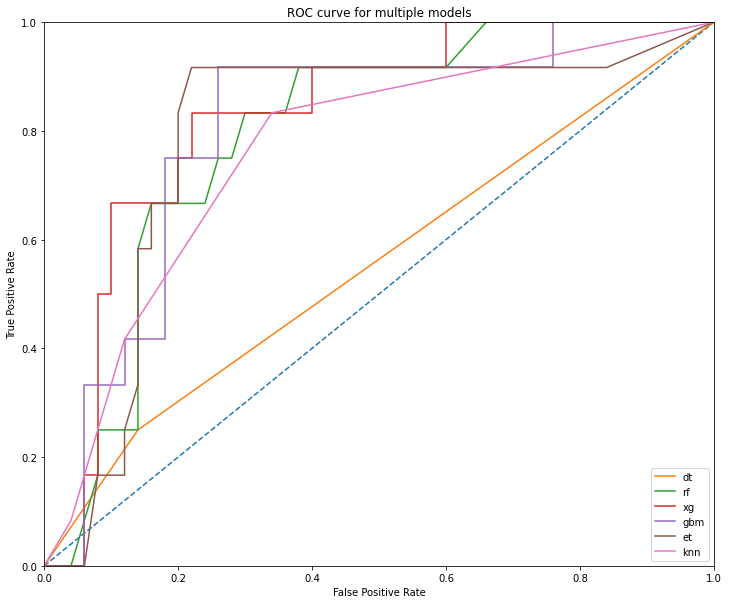

In [451]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,10))          # Create window frame
ax = fig.add_subplot(111)   # Create axes
# 9.2 Also connect diagonals
ax.plot([0, 1], [0, 1], ls="--")   # Dashed diagonal line
# 9.3 Labels etc
ax.set_xlabel('False Positive Rate')  # Final plot decorations
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve for multiple models')
# 9.4 Set graph limits
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

# 9.5 Plot each graph now
ax.plot(fpr_dt, tpr_dt, label = "dt")
ax.plot(fpr_rf, tpr_rf, label = "rf")
ax.plot(fpr_xg, tpr_xg, label = "xg")
ax.plot(fpr_gbm, tpr_gbm, label = "gbm")
ax.plot(fpr_et, tpr_et, label = "et")
ax.plot(fpr_knn, tpr_knn, label = "knn")
# 9.6 Set legend and show plot
ax.legend(loc="lower right")
plt.show()